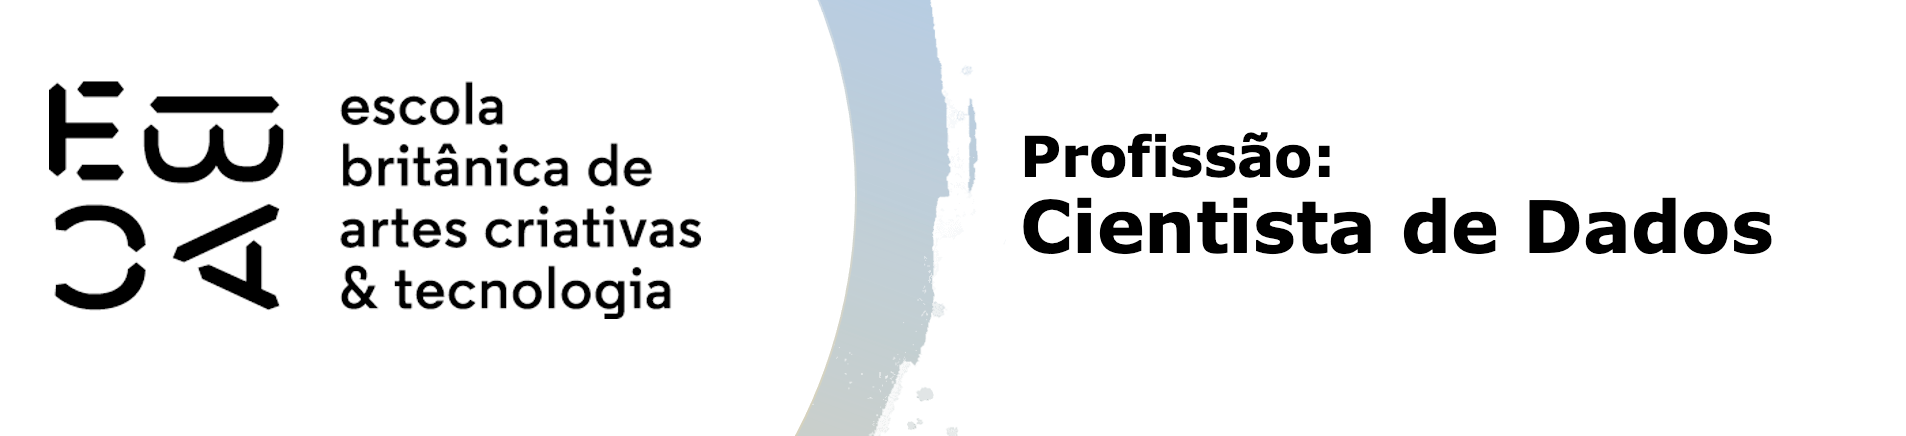

# Projeto Final

Este estudo tem o objetivo de utilizar técnicas de *machine learning* para prever o preço de fechamento das ações da Petrobrás através de técnicas de regressão linear. Não tendo em nenhum momento a intenção de recomendação de investimento.

Vamos realizar via a biblioteca ```PyCaret``` uma regressão para obter a previsão dos preços de fechamento para um período de 30 (trinta) dias, seguindo os seguintes passos:

1. Carregue os dados de uma ação da B3, no caso PETR3 (01/01/2022 até 07/11/2024);
2. Colete os dados históricos da Taxa SELIC(Sistema Especial de Liquidação e de Custódia), do DOLAR Americano e do VIX(Volatility Index ou frequentemente conhecido como "Índice do Medo");
3. Crie uma coluna categorizando o preço de fechamento do dia de acordo com a proximidade percentual (em valor absoluto), do mesmo em relação a fechamento mensal do mês anterior, conforme tabela a seguir:
|Categoria|Descrição|
|:-|:-|
|1| <= 5%|
|2|> 5% e <= 10%|
|3|> 10% e <= 15%|
|4|> 15%|

4. Exclua as linhas que apresente resultado na variável ```categoria_fechamento``` diferente da tabela acima; 
5. Junte todos os dados em um DataFrame com as seguintes variáveis: data, preco_fechamento, VIX, categoria_fechamento,  preco_dolar e taxa_selic;
6. Retire os 30 (trinta) últimos dias para a realização da previsão;
7. Visualize as correlações entre as variáveis;
8. Configure o PyCaret para receber nossos dados para modelagem;
9. Compare os modelos, realize otimização do melhor, verifique a importância de cada variável, faça avaliação com a base de teste e realize as previsões para a base de validação (30 últimos dias). 

Vamos aqui avaliar o quanto cada uma das variáveis escolhidas contribuem para explicar o preço de fechamento da PETR3. O quanto a SELIC, o DOLAR, o VIX e o valor de fechamento do mês anterior (candle mensal) influenciam no valor deste ativo.

## Importando Bibliotecas

In [1]:
import plotly.express as px
import pandas as pd
import yfinance as yf
import pandas_datareader as pdr
import requests
# Importando plotly.io e fazendo configurações para visualizar gráficos do plotly no GitHub
import plotly.io as pio
pio.renderers.default = "svg"
from datetime import datetime, timedelta
from pycaret.regression import *

## Definindo o período de busca

In [2]:
start = datetime(2022, 1, 1)
end = datetime(2024, 11, 11)

## Definindo as funções para as variáveis do DataFrame

In [3]:
# Função para buscar dados históricos de uma ação da B3 usando yfinance
def get_b3_data(ticker):
    ticker_yahoo = f"{ticker}.SA"
    df = yf.download(ticker_yahoo, start=start, end=end)
    df.reset_index(inplace=True)
    df['Date'] = pd.to_datetime(df['Date'])
    df.rename(columns={'Date': 'data', 'Close': 'preco_fechamento'}, inplace=True)
    return df[['data', 'preco_fechamento']]

In [4]:
# Função para buscar dados históricos do dólar
def get_dollar_data(): 
    url = 'https://api.bcb.gov.br/dados/serie/bcdata.sgs.10813/dados?formato=csv' 
    df = pd.read_csv(url, delimiter=';', encoding='latin1') 
    df['data'] = pd.to_datetime(df['data'], format='%d/%m/%Y') 
    df.rename(columns={'valor': 'preco_dolar'}, inplace=True) 
    # Substituir vírgulas por pontos e converter para float 
    df['preco_dolar'] = df['preco_dolar'].str.replace(',', '.').astype(float)
    return df

In [5]:
# Função para buscar dados históricos da taxa Selic
def get_selic_data(): 
    url = 'https://api.bcb.gov.br/dados/serie/bcdata.sgs.11/dados?formato=csv' 
    df = pd.read_csv(url, delimiter=';', encoding='latin1') 
    df['data'] = pd.to_datetime(df['data'], format='%d/%m/%Y') 
    df.rename(columns={'valor': 'taxa_selic'}, inplace=True)
    # Substituir vírgulas por pontos e converter para float 
    df['taxa_selic'] = df['taxa_selic'].str.replace(',', '.').astype(float)
    return df

In [6]:
# Função para buscar a série temporal de VIX (volatilidade do S&P 500) usando yfinance
def get_VIX(ticker):
    ticker_yahoo = ticker
    vix_data = yf.download(ticker_yahoo, start=start, end=end)
    vix_data.reset_index(inplace=True)
    vix_data['Date'] = pd.to_datetime(vix_data['Date'])
    vix_data.rename(columns={'Date': 'data', 'Close': 'VIX'}, inplace=True)
    # Selecionando apenas a coluna 'Close' do VIX
    vix_close = vix_data[['VIX']]
    return vix_close

In [7]:
# Função de categorização com base na proximidade ao fechamento
def categorize_proximity(Close_1, Close_2):
    # Calcula a distância percentual
    distance_percent = abs((Close_1 - Close_2) / Close_2) * 100

    # Atribui categorias com base na distância percentual
    if distance_percent <= 5:
        return 1
    elif distance_percent <= 10:
        return 2
    elif distance_percent <= 15:
        return 3
    else:
        return 4  # Ou uma outra categoria para valores fora desse intervalo

## Buscando a série temporal da ação PETR3 (Petrobras)

In [8]:
petr3_data = get_b3_data('PETR3')

[*********************100%%**********************]  1 of 1 completed


## Incorporando a variável VIX ao DataFrame de PETR3

In [9]:
vix_close = get_VIX('^VIX')
petr3_data = petr3_data.join(vix_close, how='inner')

[*********************100%%**********************]  1 of 1 completed


In [10]:
petr3_data.head()

,data,preco_fechamento,VIX
0,2022-01-03,31.520000,16.600000
1,2022-01-04,31.920000,16.910000
2,2022-01-05,30.610001,19.730000
3,2022-01-06,30.580000,19.610001
4,2022-01-07,30.830000,18.760000


## Identificando o preço de fechamento dentro do mês

In [11]:
data = petr3_data.set_index('data')
agrup = data.resample('M').agg({'preco_fechamento':'last'})
agrup.index = agrup.index.to_period('M')
agrup.head()

,preco_fechamento
data,
2022-01,35.270000
2022-02,36.369999
2022-03,35.240002
2022-04,33.439999
2022-05,33.259998


## Criando a variável "categoria_fechamento" com os ajustes previstos

In [12]:
# Cria uma coluna com o mês e o ano
data['ano_mes'] = data.index.to_period('M')

# Agrupa por mês e obtém o valor de fechamento
mes_fechamento = data.groupby('ano_mes')['preco_fechamento'].last()

# Cria uma coluna com o fechamento do mês anterior
data['mes_fechamento'] = data['ano_mes'].apply(lambda x: mes_fechamento.get(x - 1, pd.NA))

# Aplica a função de categorização
data['categoria_fechamento'] = data.apply(lambda row: categorize_proximity(row['preco_fechamento'], row['mes_fechamento']) if pd.notna(row['mes_fechamento']) else None, axis=1)

# Remove as linhas com 'NaN' 
data = data.dropna()
data.head()

,preco_fechamento,VIX,ano_mes,mes_fechamento,categoria_fechamento
data,,,,,
2022-02-01,36.310001,22.090000,2022-02,35.27,1.0
2022-02-02,35.660000,24.350000,2022-02,35.27,1.0
2022-02-03,35.279999,23.219999,2022-02,35.27,1.0
2022-02-04,35.910000,22.860001,2022-02,35.27,1.0
2022-02-07,35.480000,21.440001,2022-02,35.27,1.0


## Gerando os dados históricos para o DOLLAR e a SELIC

In [13]:
dolar_df = get_dollar_data()
selic_df = get_selic_data()

## Combinando os dataframes

In [14]:
# Resetando o índice para transformar 'data' em uma coluna regular 
data.reset_index(inplace=True)
df = data[['data','preco_fechamento','VIX','categoria_fechamento']].merge(dolar_df, on='data', how='left').merge(selic_df, on='data', how='left')
df.head()

,data,preco_fechamento,VIX,categoria_fechamento,preco_dolar,taxa_selic
0,2022-02-01,36.310001,22.090000,1.0,5.2804,0.034749
1,2022-02-02,35.660000,24.350000,1.0,5.2950,0.034749
2,2022-02-03,35.279999,23.219999,1.0,5.3019,0.040168
3,2022-02-04,35.910000,22.860001,1.0,5.3278,0.040168
4,2022-02-07,35.480000,21.440001,1.0,5.2907,0.040168


## Retirando os últimos 30 dias de pregão para testar a previsão

In [15]:
df_predict = df.tail(30)
df_predict.head()

,data,preco_fechamento,VIX,categoria_fechamento,preco_dolar,taxa_selic
666,2024-09-30,39.270000,16.959999,2.0,5.4475,0.040168
667,2024-10-01,40.320000,16.730000,1.0,5.4515,0.040168
668,2024-10-02,40.790001,19.260000,1.0,5.4299,0.040168
669,2024-10-03,41.340000,18.900000,2.0,5.4844,0.040168
670,2024-10-04,41.360001,20.490000,2.0,5.4680,0.040168


## Removendo os últimos 30 dias do dataframe original

In [16]:
df.drop(df.tail(30).index, inplace=True)
df.head()

,data,preco_fechamento,VIX,categoria_fechamento,preco_dolar,taxa_selic
0,2022-02-01,36.310001,22.090000,1.0,5.2804,0.034749
1,2022-02-02,35.660000,24.350000,1.0,5.2950,0.034749
2,2022-02-03,35.279999,23.219999,1.0,5.3019,0.040168
3,2022-02-04,35.910000,22.860001,1.0,5.3278,0.040168
4,2022-02-07,35.480000,21.440001,1.0,5.2907,0.040168


## Visualizando correlações entre as variáveis

In [17]:
Variavel = ['preco_fechamento','VIX','categoria_fechamento', 'preco_dolar', 'taxa_selic']
df[Variavel].corr()

,preco_fechamento,VIX,categoria_fechamento,preco_dolar,taxa_selic
preco_fechamento,1.000000,-0.335504,-0.159756,0.078636,-0.735198
VIX,-0.335504,1.000000,0.111994,0.187974,0.278695
categoria_fechamento,-0.159756,0.111994,1.000000,0.027212,0.201874
preco_dolar,0.078636,0.187974,0.027212,1.000000,-0.267861
taxa_selic,-0.735198,0.278695,0.201874,-0.267861,1.000000


**Análise:** 

VIX (-0.334273): correlação negativa que sugere queda do preço de fechamento do ativo a medida que o medo ao risco aumenta;

categoria_fechamento (-0.161075): correlação negativa e fraca, indica que categorias mais altas de fechamento estão levemente associadas a menores preços de fechamento;

preco_dolar (0.075004): correlação positiva e também fraca, sugere que não há uma relação forte entre o preço de fechamento do ativo e o preço do dólar; e

taxa_selic (-0.734428): Uma correlação negativa forte indica que, conforme a taxa Selic aumenta, os preços de fechamento tendem a diminuir. O aumento da SELIC leva os investidores para as aplicações de renda fixa.

## Configurando o Pycaret para receber nossos dados para modelagem

In [18]:
# Session_id para reproduzir as mesmas informações
# remove_multicollinearity => Não remover colunas com alta correlação
setup(data=df[Variavel], target='preco_fechamento', session_id=123, remove_multicollinearity=False)

,Description,Value
0,Session id,123
1,Target,preco_fechamento
2,Target type,Regression
3,Original data shape,"(666, 5)"
4,Transformed data shape,"(666, 5)"
5,Transformed train set shape,"(466, 5)"
6,Transformed test set shape,"(200, 5)"
7,Numeric features,4
8,Preprocess,True
9,Imputation type,simple


## Comparando os modelos

In [19]:
compare = compare_models()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
et,Extra Trees Regressor,1.1819,3.3200,1.7980,0.8420,0.0533,0.0353,0.0720
rf,Random Forest Regressor,1.3233,3.7441,1.9094,0.8207,0.0565,0.0395,0.0970
lightgbm,Light Gradient Boosting Machine,1.5548,4.4980,2.0968,0.7883,0.0613,0.0460,0.0570
gbr,Gradient Boosting Regressor,1.6410,4.9485,2.1951,0.7623,0.0637,0.0481,0.0410
dt,Decision Tree Regressor,1.4616,6.2305,2.4422,0.7057,0.0715,0.0435,0.0130
ada,AdaBoost Regressor,2.0990,6.8035,2.5941,0.6823,0.0758,0.0624,0.0250
lr,Linear Regression,2.5175,9.5211,3.0747,0.5524,0.0885,0.0738,0.6640
lar,Least Angle Regression,2.5175,9.5211,3.0747,0.5524,0.0885,0.0738,0.0120
huber,Huber Regressor,2.4738,9.7662,3.1103,0.5413,0.0898,0.0720,0.0210
knn,K Neighbors Regressor,2.9945,15.3434,3.9077,0.2760,0.1112,0.0871,0.0170


## Testando os dois melhores modelos 10 vezes e vendo as médias das métricas de acurácia

In [20]:
et = create_model('et', fold=10)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,1.2019,2.9757,1.7250,0.8929,0.0513,0.0366
1,1.1514,3.0164,1.7368,0.8839,0.0513,0.0342
2,1.1346,2.5586,1.5996,0.8905,0.0506,0.0362
3,1.3360,3.5766,1.8912,0.7675,0.0542,0.0395
4,1.1151,2.4131,1.5534,0.9011,0.0464,0.0336
5,1.4396,5.5762,2.3614,0.7745,0.0711,0.0428
6,1.0770,3.3860,1.8401,0.8328,0.0542,0.0316
7,0.8456,1.4932,1.2220,0.9193,0.0349,0.0243
8,1.2126,4.1329,2.0329,0.7462,0.0586,0.0351


In [21]:
rf = create_model('rf', fold=10)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,1.2882,3.0998,1.7606,0.8884,0.0514,0.0390
1,1.2128,2.7356,1.6540,0.8947,0.0490,0.0362
2,1.5557,4.3791,2.0926,0.8126,0.0648,0.0493
3,1.5712,4.4956,2.1203,0.7078,0.0616,0.0463
4,1.2878,3.5072,1.8727,0.8562,0.0561,0.0387
5,1.6095,5.8825,2.4254,0.7621,0.0732,0.0480
6,1.1034,3.5588,1.8865,0.8242,0.0554,0.0323
7,0.9108,1.5395,1.2408,0.9168,0.0355,0.0262
8,1.4064,4.9238,2.2190,0.6977,0.0642,0.0405


**Análise:**

Não houve nenhuma mudança para os dois melhores modelos.

## Otimizando os melhores modelos

In [22]:
tune_et = tune_model(et, n_iter=100, optimize='RMSE')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,1.1306,2.0894,1.4455,0.9248,0.0423,0.0333
1,1.3976,3.7451,1.9352,0.8559,0.0558,0.0407
2,1.1968,2.2617,1.5039,0.9032,0.0457,0.0365
3,1.5178,5.3613,2.3154,0.6515,0.0676,0.0448
4,1.5128,4.5440,2.1317,0.8137,0.0623,0.0444
5,1.5859,5.4940,2.3439,0.7778,0.0688,0.0459
6,1.2092,4.5311,2.1286,0.7762,0.0624,0.0349
7,1.1065,2.7029,1.6441,0.8539,0.0466,0.0314
8,1.5847,6.1068,2.4712,0.6250,0.0708,0.0441


Fitting 10 folds for each of 100 candidates, totalling 1000 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


In [23]:
tune_rf = tune_model(rf, n_iter=100, optimize='RMSE')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,1.3047,2.6241,1.6199,0.9055,0.0470,0.0389
1,1.3948,3.5439,1.8825,0.8636,0.0547,0.0407
2,1.3758,3.1210,1.7666,0.8664,0.0545,0.0429
3,1.3820,3.8773,1.9691,0.7480,0.0572,0.0406
4,1.4752,4.3243,2.0795,0.8227,0.0624,0.0447
5,1.6202,5.8927,2.4275,0.7617,0.0723,0.0478
6,1.1599,3.7732,1.9425,0.8136,0.0571,0.0336
7,0.9561,1.5724,1.2539,0.9150,0.0350,0.0271
8,1.5363,5.3823,2.3200,0.6695,0.0671,0.0436


Fitting 10 folds for each of 100 candidates, totalling 1000 fits


**Análise:**

Para o primeiro modelo a otimização apresentou resultado um pouco pior, e para o segundo houve uma pequena melhora no R².

## Testando o modelo com dados de teste

In [24]:
# Testando com dados de teste para ver as métricas de acurácia
predict_model(et)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,1.2720,3.8213,1.9548,0.8357,0.0557,0.0371


,VIX,categoria_fechamento,preco_dolar,taxa_selic,preco_fechamento,prediction_label
276,24.799999,1.0,5.1816,0.050788,28.400000,36.440599
431,21.709999,1.0,5.0158,0.047279,38.349998,37.325299
320,17.030001,2.0,4.9116,0.050788,29.200001,28.853600
557,15.690000,3.0,5.1178,0.040168,43.750000,41.007700
242,19.850000,2.0,5.2138,0.050788,29.500000,28.796900
...,...,...,...,...,...,...
30,25.670000,2.0,5.0758,0.043739,32.869999,33.874400
0,22.090000,1.0,5.2804,0.034749,36.310001,36.546000
72,26.100000,3.0,4.9586,0.047279,36.840000,37.378699
316,16.980000,1.0,4.9541,0.050788,27.490000,27.739300


## Análise gráfica

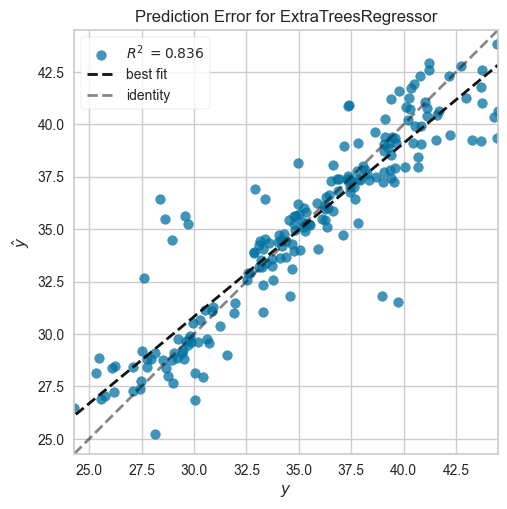

In [25]:
# Plotando gráfico de erro
plot_model(et, plot='error')

## Visualizando a importância de cada variável no modelo

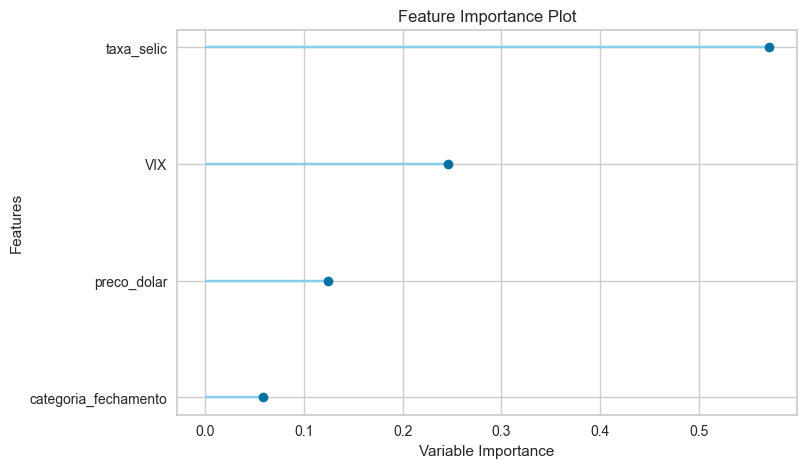

In [26]:
plot_model(et, plot='feature') # feature melhor utilizada no modelo

## Finalizando o modelo e fazendo a previsão dos últimos 30 dias de pregão

In [27]:
final_et = finalize_model(et)

## Prevendo para os ultimos 30 dias

In [28]:
prev = predict_model(final_et, data = df_predict)
prev['preco_fechamento'] = prev['preco_fechamento'].astype('float64')
prev[['preco_fechamento', 'prediction_label']].round(2)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,1.4817,2.9468,1.7166,-1.1347,0.0423,0.0368


,preco_fechamento,prediction_label
666,39.27,39.82
667,40.32,39.78
668,40.79,37.56
669,41.34,39.80
670,41.36,39.77
671,42.06,40.03
672,41.15,38.46
673,40.83,38.62
674,41.51,39.88
675,41.44,39.96


## Plotando gráfico de preços de fechamento e de previsão dos últimos 30 dias

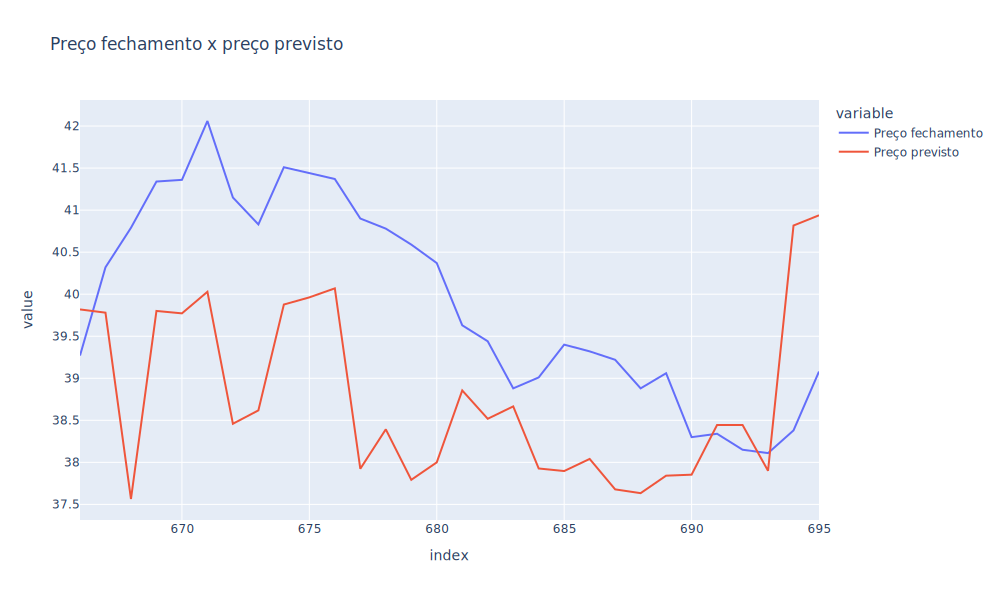

In [29]:
# Supondo que 'prev' é seu DataFrame com as colunas 'preco_fechamento' e 'prediction_label'
fig = px.line(
    prev[['preco_fechamento', 'prediction_label']], 
    x = prev.index, 
    y = ['preco_fechamento', 'prediction_label'],
    title = 'Preço fechamento x preço previsto',
    width = 1000, 
    height = 600
)

newnames = {'preco_fechamento': 'Preço fechamento', 'prediction_label': 'Preço previsto'}
fig.for_each_trace(lambda t: t.update(
    name = newnames[t.name],
    legendgroup = newnames[t.name],
    hovertemplate = t.hovertemplate.replace(t.name, newnames[t.name])
))

fig.show()

## Considerações Finais

Com a quantidade reduzida da amostra (30 dias) para a validação do modelo o R2 apresentou valor negativo de -1.1347. Bastante destoante dos valores do R2 de treino (0.8420) e do R2 de teste (0.8357).

Ficou claro que o resultado do R2 melhora a medida que a base de dados envolvida aumenta de tamanho.

Quando analisamos a importância das variáveis para o modelo, o resultado parece refletir a correlação entre as variáveis explicativas e a variável resposta. Tendo a SELIC e o VIX apresentado uma boa correlação negativa e boa importância para o modelo.